In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change this to wherever your directory is
os.chdir('/content/drive/MyDrive/CFD CW2')

# YZ Sections

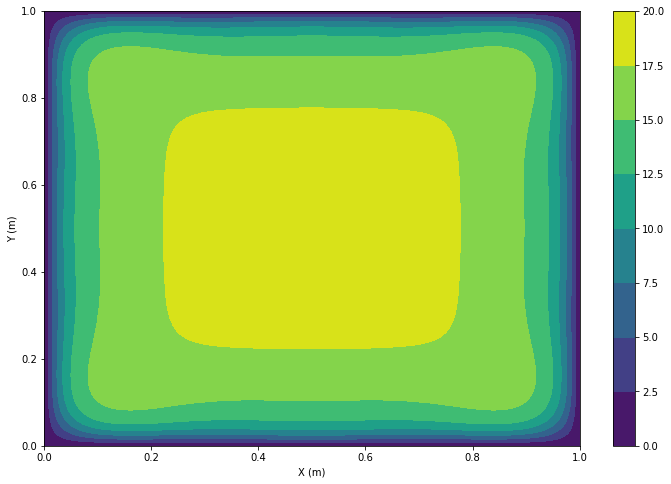

In [ ]:
fpath = 'DuctFlow/YZsections/Re300/DuctFlow_Re300_YZ.dat'

def read_yz_sections(fpath):
    df = pd.read_csv(fpath, delimiter=' ').reset_index()
    df.columns = ['y'] + list(df.iloc[0][1:])
    df = df.drop([0, 1], axis=0).reset_index(drop=True).astype('float')
    return df

df = read_yz_sections(fpath)
plt.figure(figsize=(12, 8))
plt.tricontourf(df['y'], df['z'], df['<u>'])  # x-axis, y-axis and axial velocity
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.colorbar()

# Profiles

Text(0.5, 0, 'y (m)')

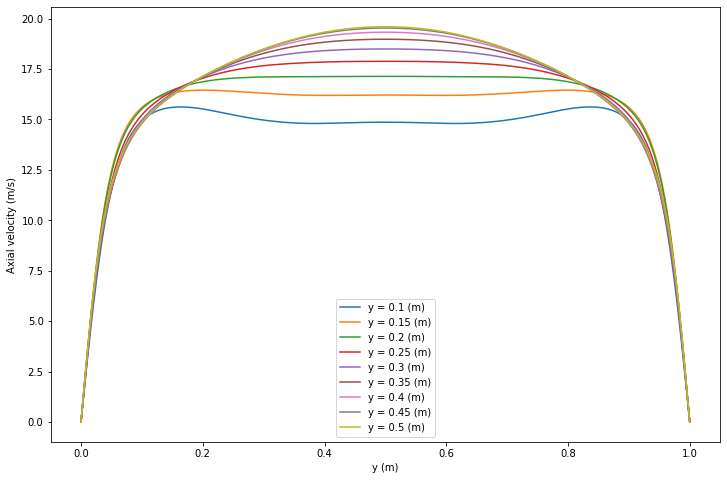

In [ ]:
re300_dir = 'DuctFlow/profiles/Re300/'
re300_fnames = ['DuctFlow_Re300_Z{}'.format(i) for i in ['010', '015', '020', '025', '030', '035', '040', '045', '050']]

plt.figure(figsize=(12, 8))

for f in re300_fnames:
    df2 = pd.read_csv(re300_dir + f, delimiter=' ', header=None)
    data = df2.iloc[2:].dropna(axis=1)
    data.columns = df2.iloc[0].dropna().values[1:]
    data = data.astype(float)
    plt.plot(data['y'].values, data['<u>'].values, label='y = {} (m)'.format(data['z'].values[0]))

plt.legend()
plt.ylabel('Axial velocity (m/s)')
plt.xlabel('y (m)')